In [1]:
from multitask_dataset import SingerMultiTaskDataset
from torch.utils.data import DataLoader
from torch.optim import Adam
import torch
from models import HuBERTFeatureFusion #, HuBERTMultiHead
import pandas as pd
from tqdm import tqdm
import numpy as np
import os
import csv

/home/maximos/miniconda3/envs/torchaudio/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# data folders
train_audio_folder = '/media/maindisk/maximos/data/melos_singers/Rebetika_vowels/train/'
test_audio_folder = '/media/maindisk/maximos/data/melos_singers/Rebetika_vowels/test/'
csv_path = '/media/maindisk/maximos/data/melos_singers/features/multitask_targets.csv'
# train_audio_folder = '/media/maximos/9C33-6BBD/data/melos_singers/Rebetika_vowels/train/'
# test_audio_folder = '/media/maximos/9C33-6BBD/data/melos_singers/Rebetika_vowels/test/'
# csv_path = '/media/maximos/9C33-6BBD/data/melos_singers/features/multitask_targets.csv'

batch_size = 8

# load csv
feats = pd.read_csv(csv_path, delimiter=',')
# keep feature list which will become the tasks
features_list = list(feats.columns)
# delete unnecessary columns
del(features_list[:2])

# keep number of outputs per task
task_labels_num_out = {}
for i in range(1, len(features_list)-3, 1):
    task_labels_num_out[features_list[i]] = 1
# add singer identification
task_labels_num_out['singer_id'] = feats['singer_id'].max()+1 # accounting for zero

# initialize model
model = HuBERTFeatureFusion(task_labels_num_out=task_labels_num_out)

# make datasets
training_data = SingerMultiTaskDataset(train_audio_folder, csv_path)
testing_data = SingerMultiTaskDataset(test_audio_folder, csv_path)

# make dataloaders
train_loader = DataLoader(training_data, batch_size=batch_size, shuffle=True, collate_fn=model.collate_fn)
test_loader = DataLoader(testing_data, batch_size=batch_size, shuffle=True, collate_fn=model.collate_fn)

You are using a model of type hubert to instantiate a model of type wav2vec2. This is not supported for all configurations of models and can yield errors.
Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/hubert-base-ls960 and are newly initialized: ['encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
saved_model_path = '/media/maindisk/maximos/repos/singer_feature_multi_regression/saved_models/frozen_hubert/frozen_hubert.pt'
model.load_state_dict(torch.load(saved_model_path), strict=False)

<All keys matched successfully>

In [4]:
b = next(iter( test_loader ))

In [5]:
training_data[0]

{'input_values': array([-0.08967178, -0.19010347, -0.2083385 , ..., -0.00820476,
        -0.00176415,  0.00736174], dtype=float32),
 'labels': {'Unnamed: 0': 287,
  'names': 'ninou_u_4',
  'singer_id': 4,
  'Pitch': 0.7754291502648109,
  'SpectralCentroid': 0.35092921737166927,
  'SpectralSpread': 0.5033758122514298,
  'SpectralSkewness': 0.45104215554233057,
  'SpectralKurtosis': 0.12069832760379844,
  'SpectralFlatness': 0.0009205238960196318,
  'SpectralCrest': 0.5512284674624198,
  'SpectralSlope': 0.3793055638224495,
  'SpectralDecrease': 0.3983801121358673,
  'SpectralRollOff': 0.33619637513544615,
  'SpectralVariation': 1.0,
  'SpectralFlux': 0.6978128892136559,
  'HarmonicSpectralDeviation': 0.1739637397326696,
  'Tristimulus_1': 0.6937424899741716,
  'Tristimulus_2': 0.381731617603988,
  'Tristimulus_3': 0.04276276024942205,
  'HarmonicOddToEvenRatio': 0.04594380763834991,
  'Inharmonicity': 0.012539580815794317,
  'HarmonicEnergy': 0.5478845770114545,
  'NoiseEnergy': 0.60951

In [6]:
print(len(training_data))
for i in range( len( testing_data ) ):
    print(testing_data[i]['labels']['names'])

336
ninou_u_1
ninou_e_1
ninou_i_1
ninou_a_1
ninou_w_1
kazantzidis_e_1
kazantzidis_w_2
kazantzidis_w_3
kazantzidis_w_1
kazantzidis_a_2
kazantzidis_i_2
kazantzidis_a_1
kazantzidis_u_1
kazantzidis_i_1
kazantzidis_a_3
bithikotsis_e_6
bithikotsis_a_10
bithikotsis_u_4
bithikotsis_i_9
bithikotsis_w_8
keti_grei_a_16
keti_grei_e_10
keti_grei_i_10
keti_grei_a_17
keti_grei_u_8
keti_grei_e_11
keti_grei_w_9
bellou_a_1
bellou_w_1
bellou_u_1
bellou_i_1
bellou_e_1
kazantzidis_old_a_2
kazantzidis_old_e_1
kazantzidis_old_i_1
kazantzidis_old_w_1
kazantzidis_old_a_1
kazantzidis_old_u_1
tsaousakis_w_2
tsaousakis_e_1


tsaousakis_u_1
tsaousakis_i_3
tsaousakis_e_2
tsaousakis_i_1
tsaousakis_a_3
tsaousakis_a_2
tsaousakis_a_1
tsaousakis_w_1
tsaousakis_i_2


In [7]:
print(len(testing_data))
for i in range(10):
    b = next(iter( test_loader ))
    print(b[1]['names'])

49
['kazantzidis_old_i_1', 'kazantzidis_w_1', 'tsaousakis_i_3', 'ninou_e_1', 'bithikotsis_w_8', 'kazantzidis_e_1', 'keti_grei_a_16', 'kazantzidis_old_a_1']
['kazantzidis_old_a_1', 'bellou_i_1', 'tsaousakis_a_3', 'ninou_i_1', 'kazantzidis_old_w_1', 'kazantzidis_old_a_2', 'bithikotsis_a_10', 'kazantzidis_u_1']
['ninou_e_1', 'tsaousakis_i_1', 'kazantzidis_old_u_1', 'keti_grei_e_10', 'keti_grei_a_17', 'tsaousakis_e_2', 'ninou_i_1', 'bithikotsis_u_4']
['kazantzidis_old_a_1', 'kazantzidis_e_1', 'bithikotsis_i_9', 'keti_grei_u_8', 'tsaousakis_a_2', 'keti_grei_e_10', 'tsaousakis_w_2', 'kazantzidis_a_1']
['bithikotsis_e_6', 'tsaousakis_e_2', 'bithikotsis_i_9', 'kazantzidis_a_1', 'keti_grei_u_8', 'kazantzidis_i_1', 'bithikotsis_a_10', 'kazantzidis_old_a_2']
['tsaousakis_u_1', 'kazantzidis_i_1', 'kazantzidis_old_a_1', 'tsaousakis_w_2', 'kazantzidis_w_2', 'kazantzidis_a_1', 'bithikotsis_u_4', 'kazantzidis_a_3']
['tsaousakis_i_2', 'kazantzidis_old_i_1', 'kazantzidis_i_1', 'kazantzidis_w_2', 'kazant

In [8]:
y = model(
    audio_normalized=b[0]['input_values'],
    attention_mask=b[0]['attention_mask'],
    labels=b[1],
    output_attentions=False,
    output_hidden_states=True,
    return_dict=True
)

In [9]:
print(y.loss)
print(b[1]['names'])
print(y.logits['singer_id'])

tensor(2.1836, device='cuda:0', grad_fn=<AddBackward0>)
['kazantzidis_w_1', 'kazantzidis_w_2', 'kazantzidis_i_2', 'tsaousakis_a_3', 'tsaousakis_e_2', 'bithikotsis_a_10', 'keti_grei_u_8', 'keti_grei_a_16']
[tensor([[1.7643e-15, 8.2617e-22, 1.0000e+00, 8.6838e-21, 2.8946e-25, 3.2690e-09],
        [9.7411e-09, 1.6223e-12, 9.9935e-01, 2.2338e-11, 6.7077e-15, 6.4897e-04],
        [1.8112e-09, 5.7061e-11, 1.2336e-05, 2.4671e-08, 1.6710e-13, 9.9999e-01],
        [6.3736e-11, 2.0761e-17, 1.0000e+00, 5.0471e-16, 1.1261e-18, 4.4006e-09],
        [1.1920e-16, 1.5982e-23, 1.0000e+00, 2.5130e-23, 1.1485e-27, 6.1152e-13],
        [3.5307e-06, 7.4670e-08, 8.0199e-03, 2.4127e-06, 4.0920e-10, 9.9197e-01],
        [4.2556e-03, 2.1898e-06, 9.9548e-01, 2.2734e-05, 2.3093e-05, 2.1449e-04],
        [1.3777e-06, 3.0504e-11, 1.9558e-10, 1.0000e+00, 2.0331e-07, 8.7638e-08]],
       device='cuda:0', grad_fn=<SoftmaxBackward0>)]


In [10]:
h = y.hidden_states['hubert']
p = y.hidden_states['projectors']
c = y.hidden_states['common_projector']

In [11]:
print(c.shape)

torch.Size([8, 512])


In [12]:
color_values = {}
hidden_states = []
common_projector = []
projectors = {}

with torch.no_grad():
    for b in train_loader:
        y = model(
            audio_normalized=b[0]['input_values'],
            attention_mask=b[0]['attention_mask'],
            labels=b[1],
            output_attentions=False,
            output_hidden_states=True,
            return_dict=True
        )
        hidden_states.append( y.hidden_states['hubert'].cpu().mean(axis=1).numpy() )
        common_projector.append( y.hidden_states['common_projector'].cpu().numpy() )
        for k in y.logits.keys():
            # color_values.setdefault(k, []).append( y.logits[k][0].cpu().numpy() )
            color_values.setdefault(k, []).append( np.array(b[1][k]) )
            projectors.setdefault(k, []).append( y.hidden_states['projectors'][k].cpu().numpy() )
    # for b in test_loader:
    #     y = model(
    #         audio_normalized=b[0]['input_values'],
    #         attention_mask=b[0]['attention_mask'],
    #         labels=b[1],
    #         output_attentions=False,
    #         output_hidden_states=True,
    #         return_dict=True
    #     )
    #     hidden_states.append( y.hidden_states['hubert'].cpu().mean(axis=1).numpy() )
    #     for k in y.logits.keys():
    #         # color_values.setdefault(k, []).append( y.logits[k][0].cpu().numpy() )
    #         color_values.setdefault(k, []).append( np.array(b[1][k]) )
    #         projectors.setdefault(k, []).append( y.hidden_states['projectors'][k].cpu().numpy() )

In [13]:
np.hstack( color_values['Pitch'] ).shape

(336,)

In [14]:
y.logits[k][0].cpu().numpy()

array([[1.0686518e-09, 2.1234926e-17, 1.2506112e-16, 1.0000000e+00,
        4.2336737e-10, 1.1054908e-13],
       [2.6084559e-09, 1.8455735e-13, 9.9999607e-01, 2.3760555e-12,
        1.3841411e-13, 3.9693023e-06],
       [7.1900291e-10, 6.9714962e-15, 9.9999261e-01, 1.9057386e-14,
        1.2644074e-16, 7.3716360e-06],
       [9.7289018e-14, 1.6298051e-15, 1.3680301e-07, 1.7892698e-12,
        3.1781788e-20, 9.9999988e-01],
       [5.2468415e-05, 2.1513553e-07, 9.9461269e-01, 6.8389556e-07,
        2.2516559e-08, 5.3339466e-03],
       [9.9174561e-14, 1.8669192e-16, 3.4380591e-07, 4.8534561e-14,
        1.1970772e-20, 9.9999964e-01],
       [1.4031872e-09, 2.3454225e-17, 2.2805499e-16, 1.0000000e+00,
        9.1667431e-11, 1.6136451e-13],
       [9.8952088e-20, 4.6986695e-30, 1.0000000e+00, 4.9775963e-28,
        1.4068195e-30, 6.5407679e-17]], dtype=float32)

In [15]:
# hs_np = np.vstack(hidden_states)
# cv_np = {}
# for k in color_values.keys():
#     if k == 'singer_id':
#         cv_np[k] = np.argmax( np.vstack( color_values[k] ), axis=1 )
#     else:
#         cv_np[k] = np.vstack( color_values[k] )
hs_np = np.vstack(hidden_states)
cp_np = np.vstack(common_projector)
cv_np = {}
for k in color_values.keys():
    cv_np[k] = np.hstack( color_values[k] )

In [16]:
print(hs_np.shape)
print(cp_np.shape)
print(cv_np['singer_id'].shape)

(336, 768)
(336, 512)
(336,)


In [17]:
from sklearn.manifold import TSNE

In [18]:
tsne = TSNE(n_components=2, learning_rate='auto',
            init='random', perplexity=30)
# X_embedded = tsne.fit_transform(hs_np)
X_embedded = tsne.fit_transform(cp_np)

In [19]:
print(X_embedded.shape)

(336, 2)


In [20]:
import matplotlib.pyplot as plt

In [21]:
color_keys = list(cv_np.keys())

Text(0.5, 1.0, 'singer_id')

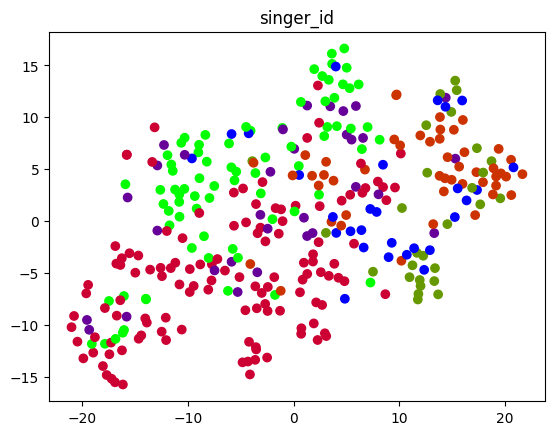

In [22]:
# col = color_keys[1]
col = 'singer_id'
plt.scatter( X_embedded[:,0], X_embedded[:,1], c=cv_np[col], cmap='brg'  )
plt.title(col)

In [23]:
# make numpy for all projectors
projectors_np = {}
projectors_tsne = {}
for k in projectors.keys():
    projectors_np[k] = np.vstack(projectors[k])
    projectors_tsne[k] = tsne.fit_transform(projectors_np[k])

In [24]:
os.makedirs('figs', exist_ok=True)

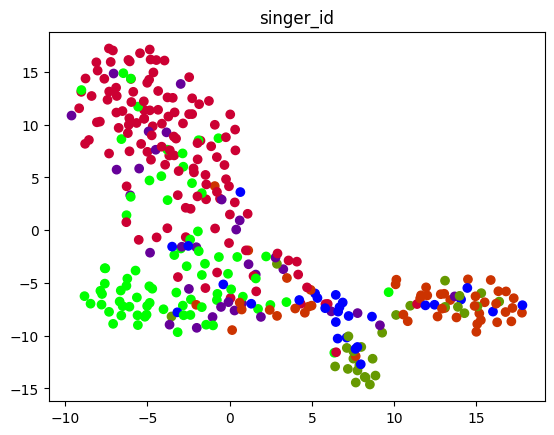

In [25]:
for k in projectors.keys():
    X_embedded = projectors_tsne[k]
    plt.clf()
    plt.scatter( X_embedded[:,0], X_embedded[:,1], c=cv_np[k], cmap='brg' ) # c=cv_np['singer_id'] )
    plt.title(k)
    plt.savefig('figs/' + k + '.png', dpi=300)